[View in Colaboratory](https://colab.research.google.com/github/3catz/power_consumption_timeseries/blob/master/LSTMS_and_Nonlinear_Time_Series.ipynb)

# **Stacked Bidirectional LSTMs with Attention vs Prophet and standard SARIMA models of time series*

In [0]:
!pip install keras 

In [0]:
!pip install Prophet

In [2]:
!pip install keras 
!pip install Prophet
from sklearn.preprocessing import MinMaxScaler, RobustScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
#pandas imports 
#import pandas_datareader.data as web
from pandas import Series
from pandas import DataFrame
from pandas import concat

import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os 

from scipy.integrate import odeint
#keras 
from keras.models import *
from keras.layers import * 
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np

from pandas import DataFrame
from pandas import concat

from matplotlib import pyplot
import pywt
import prophet

Using TensorFlow backend.


### **Series to Supervised Code, courtesy of Jason Brownlee**

In [253]:
def series_to_supervised(data, n_in, n_out, dropnan=True):

	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

    



### Attention with Context 

In [254]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
   

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]



In [11]:
from google.colab import files; files.upload()

Saving HL1.dat to HL1.dat


{'HL1.dat': b'35.41,18.17,51.06,22.71,21.42,37.4,28.19,21.16,15.83,37.87,18.07,40.32,22.39,32.3,30.34,25.52,19.37,29.87,16.75,27.67,27.23,30.8,35.48,24.44,20.55,15.74,29.44,14.22,27.42,15.92,45.06,13.36,25.33,30.64,22.67,20.62,17.91,29.99,24.74,32.13,15.05,24.84,32.54,28.45,37.42,45.17,27.47,34.55,30.35,15,26.08,23.62,13.19,25.08,16.57,17.1,35.38,20.65,20.54,16.63,7.22,8.35,20.34,30.28,22.45,33.58,22.91,43.13,26.91,31.89,35.9,22.82,30.88,35.86,61.01,42,45.52,32.6,72.92,15.04,46.31,33.95,64.4,60.18,72.74,58.39,39.06,33.31,47,94.32,42.91,32.25,44.48,24.56,52.67,51.98,36.2,16.75,39.79,34.73,47.71,95.24,47.03,43.45,64.39,75.86,32.97,41.89,65.9,81.88,90.61,72.24,94.18,96.56,96.06,50.09,76.68,89.59,55.68,49.21,26.26,54.25,102.65,28.23,32.16,17.62,34.09,49.76,52.01,77.64,54.46,45.56,58.22,21.28,38.44,22.3,44.15,27.3,27.71,38.97,15.01,30.84,14.85,16.89,15.02,12.44,25.6,15.5,16.18,14.85,13.54,25.71,11.31,23.27,19.17,19.15,21.74,35.74,22.22,15.67,30.21,13.04,15.98,18.96,19.81,26.82,25.72,11.48,3

In [3]:
!wget http://www.comp-engine.org/timeseries/query-csv?q=90575

--2018-07-03 03:47:03--  http://www.comp-engine.org/timeseries/query-csv?q=90575
Resolving www.comp-engine.org (www.comp-engine.org)... 155.198.64.5, 146.179.40.5, 2001:630:12:600:1:2:0:7, ...
Connecting to www.comp-engine.org (www.comp-engine.org)|155.198.64.5|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://www.comp-engine.org/timeseries/query-csv/?q=90575 [following]
--2018-07-03 03:47:05--  http://www.comp-engine.org/timeseries/query-csv/?q=90575
Reusing existing connection to www.comp-engine.org:80.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/dat]
Saving to: ‘query-csv?q=90575.2’

query-csv?q=90575.2     [  <=>               ] 129.86K   480KB/s    in 0.3s    

2018-07-03 03:47:06 (480 KB/s) - ‘query-csv?q=90575.2’ saved [132977]



In [4]:
dfx = np.fromfile("query-csv?q=90575")
print(dfx)

[4.05626179e-86 1.08557690e-71 8.98880417e-96 ... 1.13242132e-95
 3.65410884e-86 5.93050215e-38]


# Load the Data

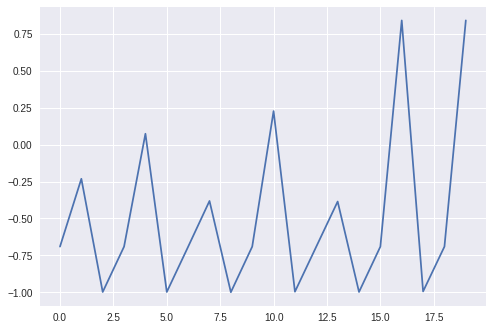

In [5]:
import numpy as np

#taking logs of everything first 
dfx = dfx.reshape(-1,1)
log_df = np.log(dfx)
DataFrame(log_df)
scaler = MinMaxScaler(feature_range = (-1,1))
log_df_scaled = scaler.fit_transform(log_df)
plt.plot(log_df_scaled[0:20])
plt.show()

In [8]:
from pandas import Series
from statsmodels.tsa.stattools import adfuller
 

def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return Series(diff)
 
X = np.squeeze(log_df_scaled)
X = Series(X)
# difference data
stationary = difference(X)
stationary.index = X.index[1:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -32.801824
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


# ACF and PCF plots

In [259]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

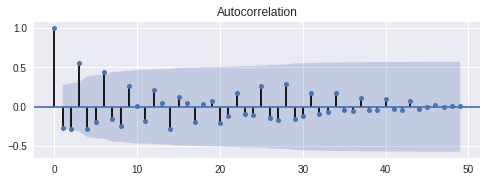

In [260]:
pyplot.figure()
pyplot.subplot(211)
g = plot_acf(log_df_scaled, ax=pyplot.gca())

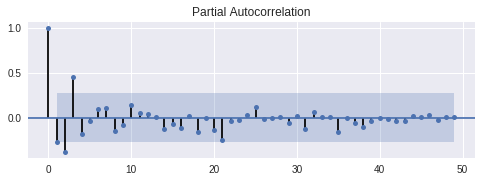

In [261]:
pyplot.subplot(212)
plot_pacf(log_df_scaled[:50], ax=pyplot.gca())
pyplot.show()

# PCF and ACF of the differenced series 

In [6]:
stationary = np.reshape(stationary, (-1,1))
print(stationary.shape)
scaler = MinMaxScaler(feature_range = (-1,1))
stationary_scaled = scaler.fit_transform(stationary)

pyplot.figure()
pyplot.margins(x = .1, y = .1)
pyplot.plot(stationary_scaled[1322:1389])
pyplot.show()

#pyplot.subplot(211)
#g = plot_acf(stationary_scaled[:1000], ax=pyplot.gca())

#pyplot.subplot(212)
#plot_pacf(stationary_scaled[:1000], ax=pyplot.gca())
#pyplot.show()

NameError: ignored

# Discrete Wavelet Transform

In [402]:
wavelet_type = "db4" #@param {type:"string"}
transform_level = 3 #@param {type:"slider", min:1, max:8, step:1}
modes = "smooth" #@param {type:"string"}


# Wavelet Denoising and smoothing - - using only the approximation coefficients, i.e. eliminating all levels of detail coefficients.

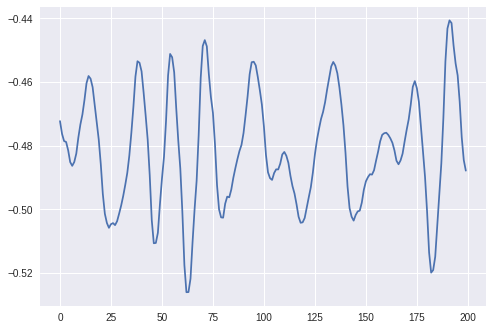

In [403]:

coeffs = pywt.downcoef("a", np.squeeze(stationary_scaled[:,0]), wavelet = wavelet_type, mode = modes, level = transform_level)

df_rec = pywt.upcoef("a", coeffs, wavelet_type, level = transform_level, take = len(stationary_scaled))
df_rec = df_rec.reshape(-1,1)
scaler = MinMaxScaler(feature_range = (-1,1))
df_rec_scaled = scaler.fit_transform(df_rec)

plt.plot(df_rec_scaled[2000:2200])
plt.show()


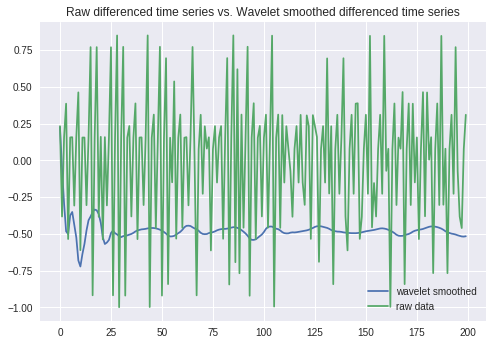

In [404]:

plt.title("Raw differenced time series vs. Wavelet smoothed differenced time series")
plt.plot(df_rec_scaled[:200], label = "wavelet smoothed")
plt.plot(stationary_scaled[:200], label = "raw data")
plt.legend()
plt.show()




KeyboardInterrupt: ignored

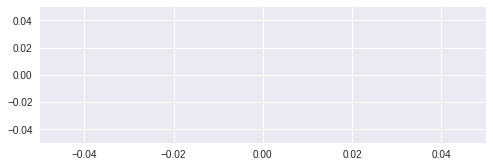

In [405]:
ax = pyplot.subplot(212)
ax.margins(x = 0.00001, y = 0)
ax = plot_pacf(df_rec_scaled[0:2000], ax=pyplot.gca())

pyplot.show()


**The ACF and PACF plots show that there is significant autocorrelation for the first two lags**

In [400]:
print(df_rec_scaled.shape)

(16621, 1)


In [406]:

# check if stationary
result = adfuller(df_rec_scaled[:,0])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.693146
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


# We can conclude there is no trend, that this is a stationary series 

# Transforming the data into a supervised learning problem

In [603]:
n_in = 4 #@param {type:"slider", min:0, max:1000, step:2}
n_out = 1 #@param {type:"slider", min:1, max:100, step:1}
testratio = 0.15 #@param {type:"slider", min:0, max:1, step:0.05}


In [604]:
df2 = series_to_supervised(df_rec_scaled, n_in = n_in, n_out = n_out, dropnan = True)
print(df2.shape)
df2 = np.asarray(df2)

(16617, 5)


## Creating Training, Validation and Testing sets

In [605]:
train, test = train_test_split(df2, shuffle = False, test_size = testratio)
valid, test = train_test_split(test, shuffle = False)
train.shape, valid.shape, test.shape

((14124, 5), (1869, 5), (624, 5))

# Reshaping the input for the LSTM shape 

In [606]:
trainX = train[:,:-n_out]
trainY = train[:,-n_out:]
testX = test[:,:-n_out]
testY = test[:,-n_out:]
validX = valid[:,:-n_out]
validY = valid[:,-n_out:]

trainX = trainX.reshape(trainX.shape[0], 1, trainX.shape[1])
testX = testX.reshape(testX.shape[0], 1, testX.shape[1])
validX = validX.reshape(validX.shape[0], 1, validX.shape[1])
print(trainX.shape, validX.shape, testX.shape, trainY.shape, validY.shape, testY.shape)

(14124, 1, 4) (1869, 1, 4) (624, 1, 4) (14124, 1) (1869, 1) (624, 1)


## ***2. The Original Data***

---


In [0]:
scaler = MinMaxScaler(feature_range = (-1,1))
bob = bob.reshape(-1,1)
bob_scaled = scaler.fit_transform(bob)

bob_s = series_to_supervised(bob_scaled, n_in = n_in, n_out = n_out, dropnan = True)
print(bob_s.shape)
#df = np.asarray(df)
#df = df.reshape(-1,1)
bob_s = np.asarray(bob_s)

(17033, 71)


In [0]:
train_orig, test_orig = train_test_split(bob_s, shuffle = False, test_size = testratio)
valid_orig, test_orig = train_test_split(test_orig, shuffle = False)
train_orig.shape, valid_orig.shape, test_orig.shape

trainX_orig = train_orig[:,:-n_out]
trainY_orig = train_orig[:,-n_out:]
testX_orig = test_orig[:,:-n_out]
testY_orig = test_orig[:,-n_out:]
validX_orig = valid_orig[:,:-n_out]
validY_orig = valid_orig[:,-n_out:]

trainX_orig = trainX_orig.reshape(trainX_orig.shape[0], 1, trainX_orig.shape[1])
testX_orig = testX_orig.reshape(testX_orig.shape[0], 1, testX_orig.shape[1])
validX_orig = validX_orig.reshape(validX_orig.shape[0], 1, validX_orig.shape[1])
print(trainX_orig.shape, validX_orig.shape, testX_orig.shape, trainY_orig.shape, validY_orig.shape, testY_orig.shape)

(11923, 1, 70) (3832, 1, 70) (1278, 1, 70) (11923, 1) (3832, 1) (1278, 1)


# Model Hyperparameters

In [607]:
#@title neuron, batch, epoch, dropout, callback etc hyperparameters
neurons1 = 64 #@param {type:"slider", min:0, max:100, step:2}
neurons2 = 63 #@param {type:"slider", min:0, max:100, step:1}
neurons3 = 17 #@param {type:"slider", min:0, max:100, step:1}
epochs = 20 #@param {type:"slider", min:0, max:100, step:1}
dp = 0.65 #@param {type:"slider", min:0, max:1, step:0.05}
d1 = 23 #@param {type:"slider", min:1, max:50, step:1}
d2 = 23 #@param {type:"slider", min:1, max:50, step:1}
myweights = "SPIDR_minly.hdf5" #@param {type:"string"}
bsize = 120 #@param {type:"slider", min:0, max:1000, step:10}



# ***The Model ***

In [632]:
from keras.layers.advanced_activations import *
from keras.regularizers import l2 

inputs = Input(shape = (1, n_in))

x = Bidirectional(LSTM(neurons1, return_sequences = True, 
                       dropout = 0.5, recurrent_dropout = 0.5, activation = "relu"), 
                       input_shape = inputs.shape)(inputs)
x = AttentionWithContext()(x)
x = Reshape((1, 2 * neurons1))(x)

x = Bidirectional(LSTM(neurons2, return_sequences = True, activation = "relu", 
                       kernel_initializer = "he_normal", 
                       recurrent_dropout = 0.5, dropout = 0.5))(x)
x = AttentionWithContext()(x)

#x = Reshape((1, 2 * neurons2))(x)
#x = Bidirectional(LSTM(neurons3, return_sequences = True))(x)
#x = AttentionWithContext()(x)
#x = Dense(d1, activation = "tanh")(x)
#x = Reshape((1,d1))(x)
#x = AttentionWithContext()(x)

x = Dense(d2, activation = "relu")(x)
x = Reshape((1,d2))(x)
x = AttentionWithContext()(x)

predictions = Dense(1, kernel_initializer = "he_normal", activation = "tanh")(x)
#x = AttentionWithContext()(x)
#predictions = Dense(n_out, activation = "tanh")(x)
model = Model(inputs = inputs, outputs = predictions)


opt = adam(lr = 1e-3, clipnorm = 1.0)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor = 0.9, patience = 10, min_lr = 0.0000001, verbose=1)
checkpointer = ModelCheckpoint(filepath = myweights, verbose=1, save_best_only=True)
early = EarlyStopping(monitor='val_loss', min_delta = 1e-5, patience = 10, verbose = 1, mode = 'auto')

model.compile(optimizer=opt, 
              loss='mean_absolute_percentage_error',
              metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_67 (InputLayer)        (None, 1, 4)              0         
_________________________________________________________________
bidirectional_123 (Bidirecti (None, 1, 76)             13072     
_________________________________________________________________
attention_with_context_149 ( (None, 76)                5928      
_________________________________________________________________
reshape_105 (Reshape)        (None, 1, 76)             0         
_________________________________________________________________
bidirectional_124 (Bidirecti (None, 1, 70)             31360     
_________________________________________________________________
attention_with_context_150 ( (None, 70)                5040      
_________________________________________________________________
dense_87 (Dense)             (None, 23)                1633      
__________

In [633]:
#@title Fitting the Model
history = model.fit(trainX, trainY, 
          epochs = epochs, 
          batch_size = bsize, 
          verbose = 2, 
          validation_data = (validX, validY),
          callbacks = [reduce_lr, early],
          shuffle = False)

Train on 14124 samples, validate on 1869 samples
Epoch 1/20
 - 44s - loss: 9.2879 - acc: 0.0000e+00 - val_loss: 6.0906 - val_acc: 0.0000e+00
Epoch 2/20
 - 18s - loss: 3.8692 - acc: 0.0000e+00 - val_loss: 5.1598 - val_acc: 0.0000e+00
Epoch 3/20
 - 17s - loss: 3.8214 - acc: 0.0000e+00 - val_loss: 4.9658 - val_acc: 0.0000e+00
Epoch 4/20
 - 18s - loss: 3.7436 - acc: 0.0000e+00 - val_loss: 6.9834 - val_acc: 0.0000e+00
Epoch 5/20
 - 18s - loss: 3.6570 - acc: 0.0000e+00 - val_loss: 6.1217 - val_acc: 0.0000e+00
Epoch 6/20
 - 17s - loss: 3.3676 - acc: 0.0000e+00 - val_loss: 7.2942 - val_acc: 0.0000e+00
Epoch 7/20
 - 18s - loss: 3.1623 - acc: 0.0000e+00 - val_loss: 7.4410 - val_acc: 0.0000e+00
Epoch 8/20
 - 17s - loss: 3.0419 - acc: 0.0000e+00 - val_loss: 6.8528 - val_acc: 0.0000e+00
Epoch 9/20
 - 17s - loss: 2.9238 - acc: 0.0000e+00 - val_loss: 7.6537 - val_acc: 0.0000e+00
Epoch 10/20


KeyboardInterrupt: ignored

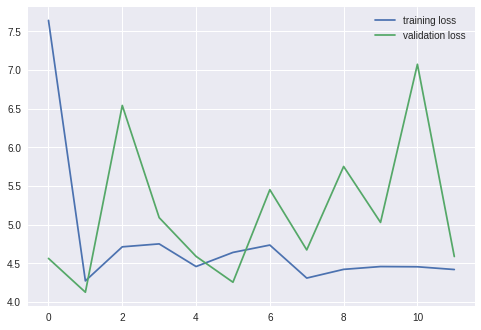

In [634]:
plt.plot(history.history["loss"], label = "training loss")
plt.plot(history.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

plt.clf()
plt.cla()
plt.close()





-0.0964018127009032


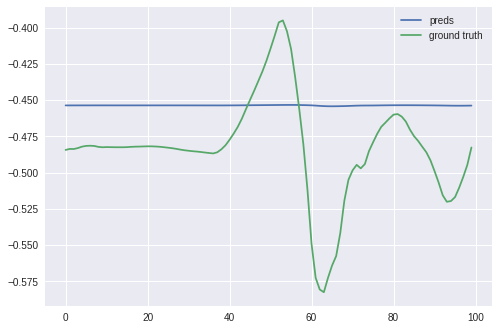

In [636]:
preds = model.predict(testX, batch_size = 100)
print(r2_score(testY, preds))



plt.plot(preds[300:400], label = "preds")
plt.plot(testY[300:400], label = "ground truth")
plt.legend()
plt.show()

plt.clf()
plt.cla()
plt.close()

In [474]:
!pip install fbprophet

    100% |████████████████████████████████| 3.4MB 10.8MB/s 
    100% |████████████████████████████████| 68.1MB 694kB/s 
  Running setup.py bdist_wheel for fbprophet ... - error
  Complete output from command /usr/bin/python3 -u -c "import setuptools, tokenize;__file__='/tmp/pip-install-r5f32bq8/fbprophet/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /tmp/pip-wheel-revt19oj --python-tag cp36:
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib
  creating build/lib/fbprophet
  creating build/lib/fbprophet/stan_model
  Traceback (most recent call last):
    File "<string>", line 1, in <module>
    File "/tmp/pip-install-r5f32bq8/fbprophet/setup.py", line 123, in <module>
      """
    File "/usr/local/lib/python3.6/dist-packages/setuptools/__init__.py", line 129, in setup
      return distutils.core.setup(**attrs)
    File "/usr/lib/pytho

# Using Facebook Prophet as a comparison

In [569]:
from fbprophet import Prophet

m = Prophet()

print(df_rec_scaled.shape)
ts = Series(df_rec_scaled[:15988,0])
print(ts.shape)

(16621, 1)
(15988,)


In [572]:
ts2 = Series(ts)
print(ts2.shape)

(15988,)


In [574]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

date_today = datetime.now()
days = pd.date_range(date_today, date_today + timedelta(15987), freq='D')

df = pd.DataFrame({'ds': days, 'y': ts2[:]})
print(df)

                              ds         y
0     2018-07-03 02:39:05.957934  0.224827
1     2018-07-04 02:39:05.957934 -0.059503
2     2018-07-05 02:39:05.957934 -0.293651
3     2018-07-06 02:39:05.957934 -0.482966
4     2018-07-07 02:39:05.957934 -0.501701
5     2018-07-08 02:39:05.957934 -0.375011
6     2018-07-09 02:39:05.957934 -0.351644
7     2018-07-10 02:39:05.957934 -0.436496
8     2018-07-11 02:39:05.957934 -0.525325
9     2018-07-12 02:39:05.957934 -0.681184
10    2018-07-13 02:39:05.957934 -0.722441
11    2018-07-14 02:39:05.957934 -0.637322
12    2018-07-15 02:39:05.957934 -0.568888
13    2018-07-16 02:39:05.957934 -0.477061
14    2018-07-17 02:39:05.957934 -0.407845
15    2018-07-18 02:39:05.957934 -0.382737
16    2018-07-19 02:39:05.957934 -0.352425
17    2018-07-20 02:39:05.957934 -0.335166
18    2018-07-21 02:39:05.957934 -0.340096
19    2018-07-22 02:39:05.957934 -0.365713
20    2018-07-23 02:39:05.957934 -0.425656
21    2018-07-24 02:39:05.957934 -0.523875
22    2018-

In [575]:
m = Prophet()
m.fit(df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.6/dist-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [588]:
future = m.make_future_dataframe(periods=623, include_history = False)
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
618,2063-12-20 02:39:05.957934,-0.481779,-0.513952,-0.451640
619,2063-12-21 02:39:05.957934,-0.481992,-0.514148,-0.448959
620,2063-12-22 02:39:05.957934,-0.482083,-0.515107,-0.449806
621,2063-12-23 02:39:05.957934,-0.482157,-0.513868,-0.449367
622,2063-12-24 02:39:05.957934,-0.482266,-0.515363,-0.451897


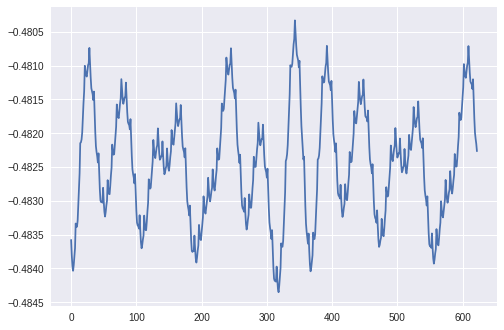

In [602]:
pyplot.plot(forecast["yhat"])

In [11]:
from scipy import signal
f, Sk = signal.periodogram(stationary, nfft = len(stationary), return_onesided = True, scaling = "spectrum")
 # Check that sum(Sk) equals variance of x
#np.sum(Sk) == np.var(df_rec_scaled)


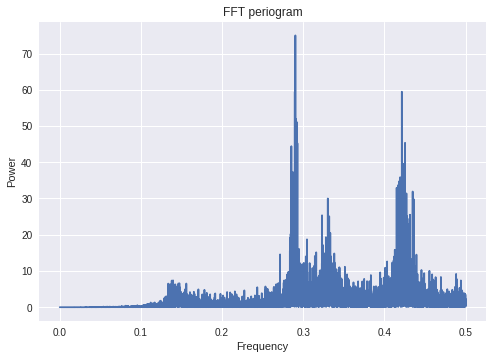

In [13]:
!pip install pyageng
import pyageng
pyageng.pfft(stationary)